# Trend Analysis 
This notebook contains code for analyzing average per capita consumption trends.
Then the total population is multiplied and SSP scenarios are created

In [1]:
## Importing the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [75]:
## Load datasets
# Loading the data from the auxiliary folder
root_path = r'\\home.ansatt.ntnu.no\avijitvp\Documents\GitHub\food-consumption'
file_path = os.path.join(root_path, 'data', 'auxiliary')
nk2_filename = 'average percapita consumption_nk2.xlsx'
nk3_filename = 'average percapita consumption_nk3.xlsx'
nk2_df = pd.read_excel(os.path.join(file_path, nk2_filename))
nk3_df = pd.read_excel(os.path.join(file_path, nk3_filename))

# Add year columns
nk2_df['Year'] = 1994
nk3_df['Year'] = 2014

# Concatenate the two dataframes
nk_df = pd.concat([nk2_df, nk3_df], ignore_index=True)

## Data Cleaning and Preparation
#dropping the TotalPhosphorus column
nk_df.drop(columns=['TotalPhosphorus'], inplace=True)

In [78]:
# Step 1: Calculate group total calories and scaling factor
group_totals = nk_df.groupby(['AgeGroup', 'Year']).agg({
    'TotalCalories': 'sum',
    'AverageEnergyIntake': 'mean'
}).reset_index()
group_totals = group_totals.rename(columns={'TotalCalories': 'GroupTotalCalories'})

# Calculate scaling factor for each group
group_totals['ScalingFactor'] = group_totals['AverageEnergyIntake'] / group_totals['GroupTotalCalories']

# Debug print to check group_totals
print("Group Totals with Scaling Factor:")
print(group_totals.head())

# Merge scaling factors back into the original dataframe
nk_df = nk_df.merge(group_totals[['AgeGroup', 'Year', 'ScalingFactor']], on=['AgeGroup', 'Year'], how='left')

# Debug print to check nk_df after merge
print("DataFrame after merging Scaling Factor:")
print(nk_df.head())

# Step 2: Apply scaling factor to each food category
# Identify food category columns
food_categories = [col for col in nk_df.columns if col not in [
    'AgeGroup', 'Year', 'Gender', 'TotalCalories', 'AverageEnergyIntake', 'ScalingFactor'
]]

# Apply scaling factor to each food category
for category in food_categories:
    nk_df[category] = nk_df[category] * nk_df['ScalingFactor']

# Recalculate TotalCalories based on adjusted food categories
nk_df['TotalCalories'] = nk_df[food_categories].sum(axis=1)

# Step 3: Verify that TotalCalories matches AverageEnergyIntake
verification = nk_df.groupby(['AgeGroup', 'Year']).agg({
    'TotalCalories': 'sum',
    'AverageEnergyIntake': 'mean'
}).reset_index()

print(verification[['AgeGroup', 'Year', 'TotalCalories', 'AverageEnergyIntake']])


Group Totals with Scaling Factor:
  AgeGroup  Year  GroupTotalCalories  AverageEnergyIntake  ScalingFactor
0    10-19  1994         7040.237097          2748.565966       0.390408
1    10-19  2014         5870.078903          2384.298287       0.406178
2    20-29  1994         6523.069424          2545.411090       0.390217
3    20-29  2014         6554.755547          2492.506200       0.380259
4    30-39  1994         5997.161857          2342.256214       0.390561
DataFrame after merging Scaling Factor:
   Gender AgeGroup            FoodCategory  TotalDryMatter   TotalFat  \
0  Female    10-19  Dairy and alternatives      179.980625  80.989347   
1  Female    10-19                    Eggs        3.043333   1.455667   
2  Female    10-19           Fats and oils       21.250746  20.312647   
3  Female    10-19                    Fish       11.332143   3.057797   
4  Female    10-19         Fruits and nuts       99.337017  25.302486   

   TotalProtein  TotalCarbohydrates  TotalCalorie

TypeError: can't multiply sequence by non-int of type 'float'

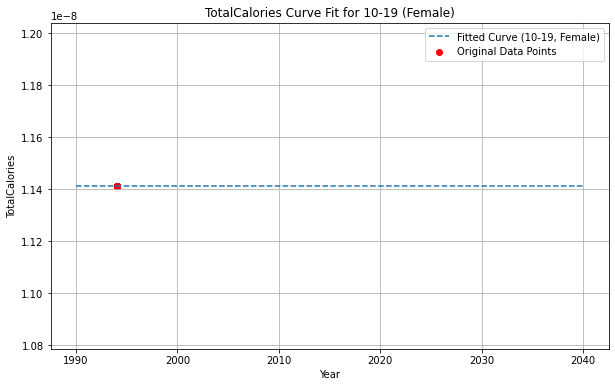

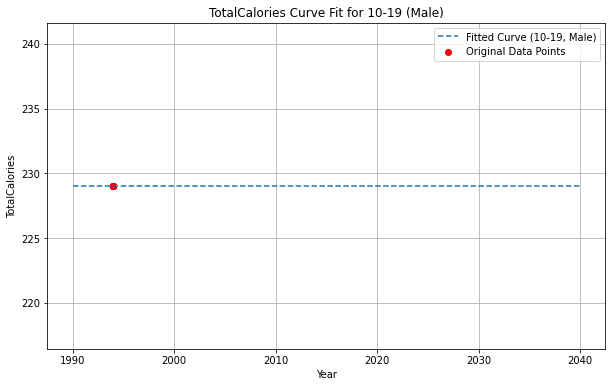

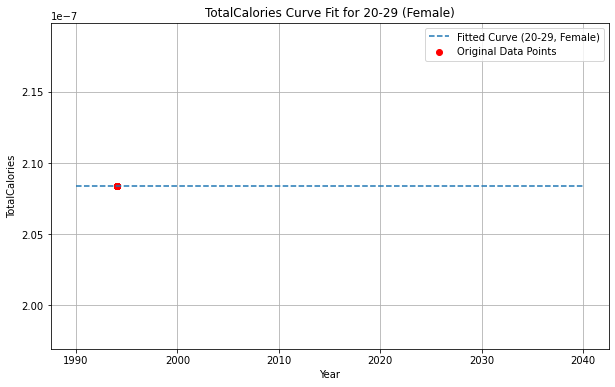

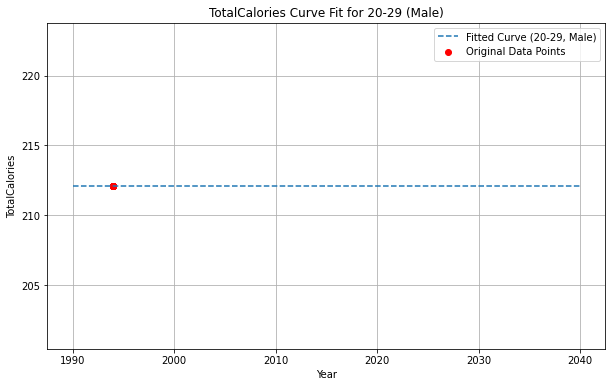

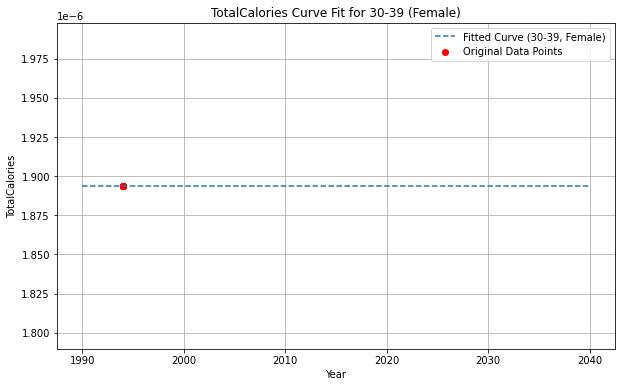

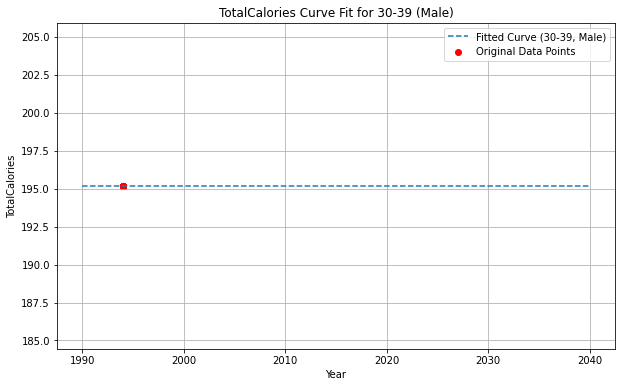

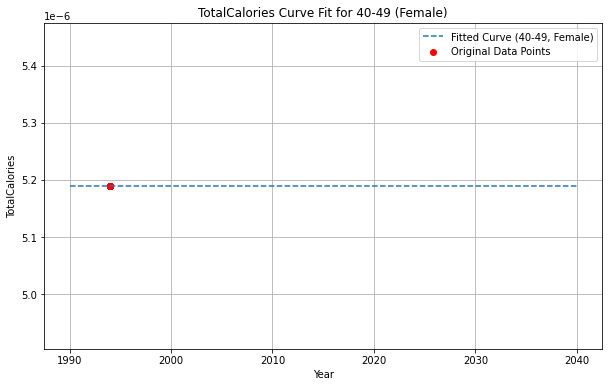

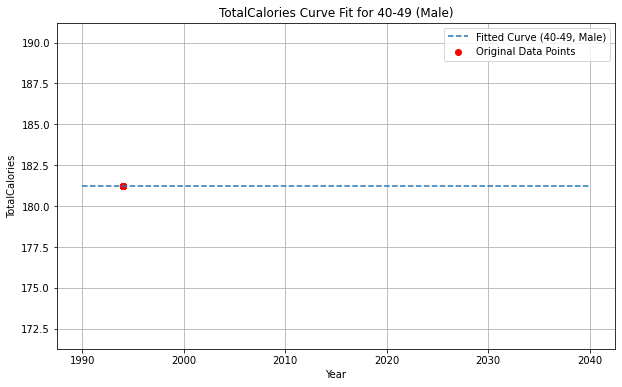

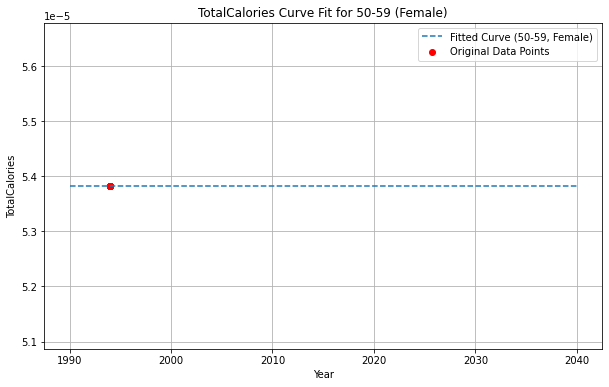

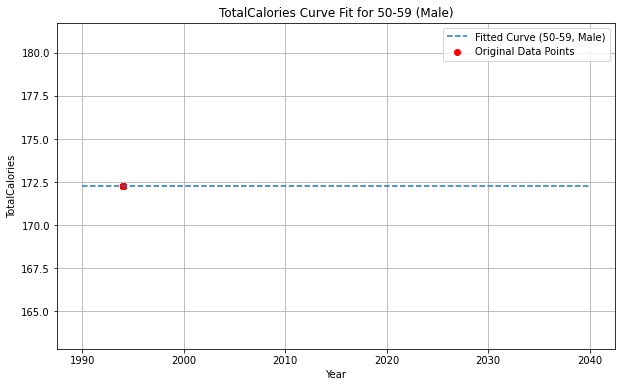

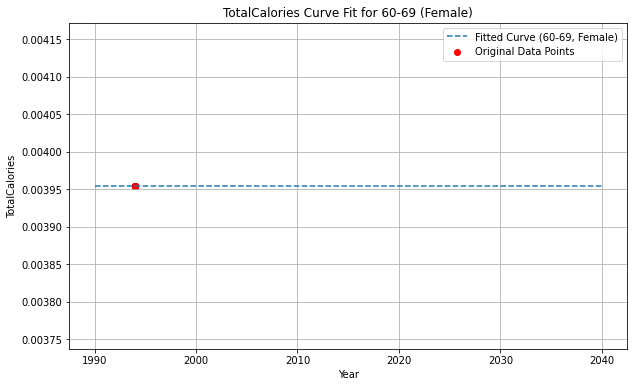

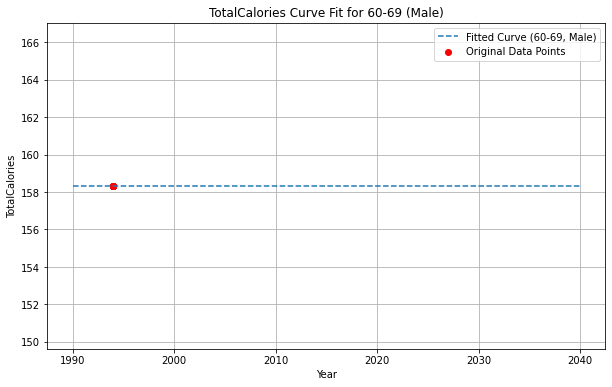

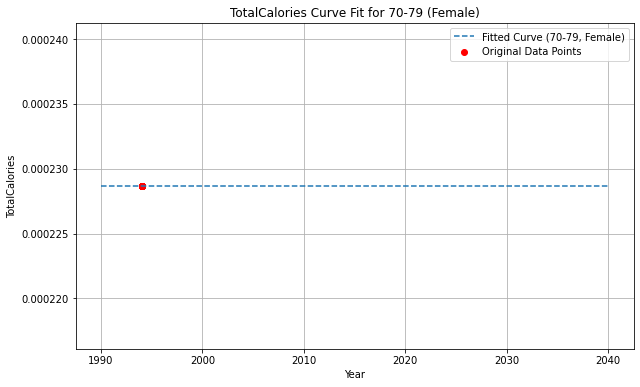

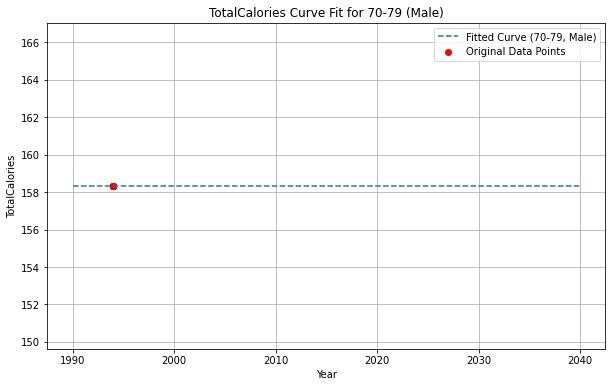

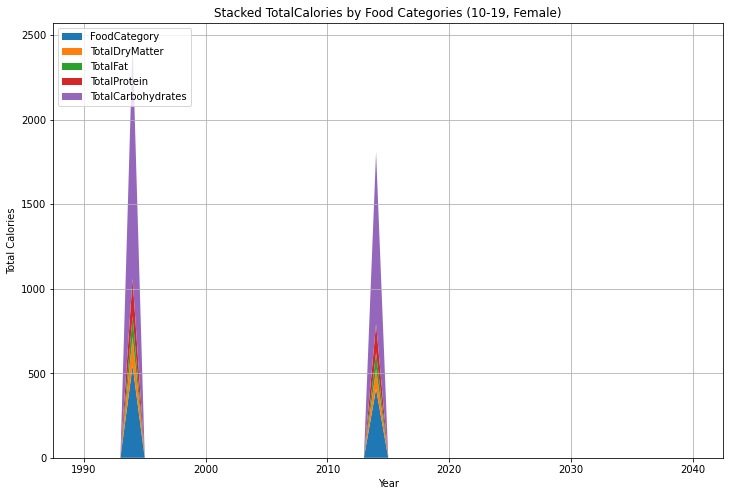

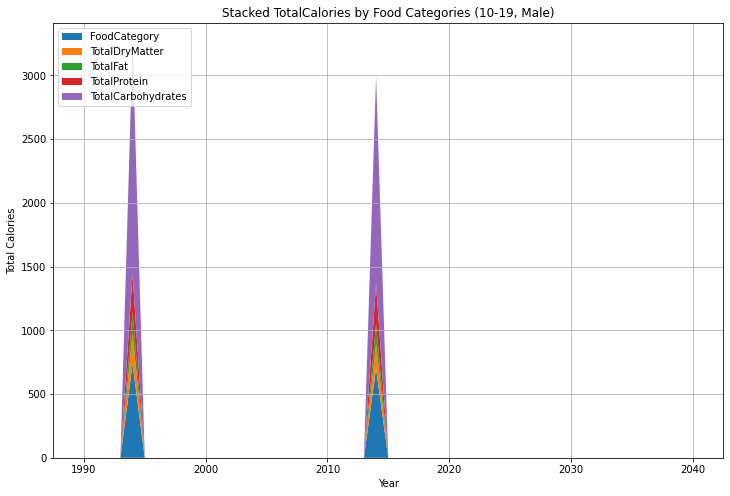

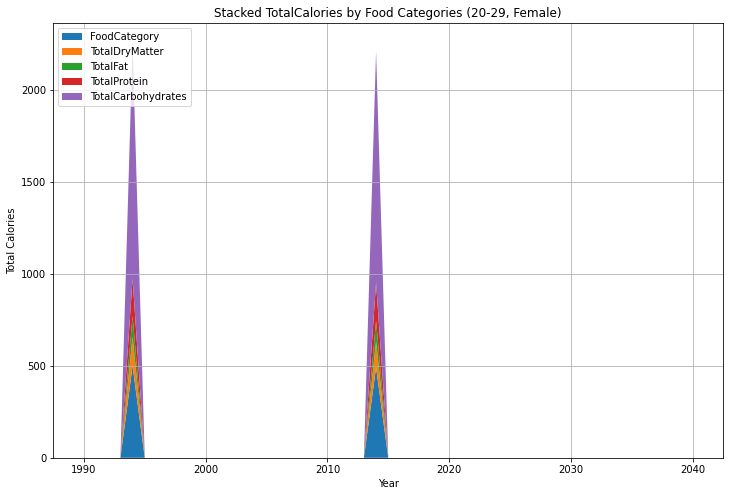

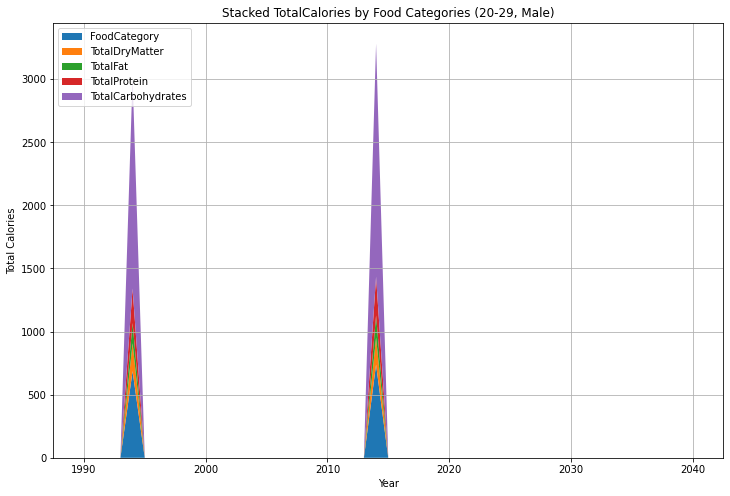

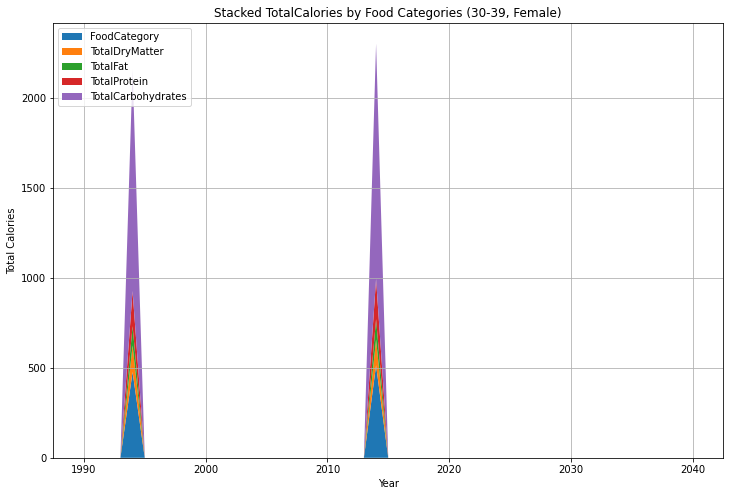

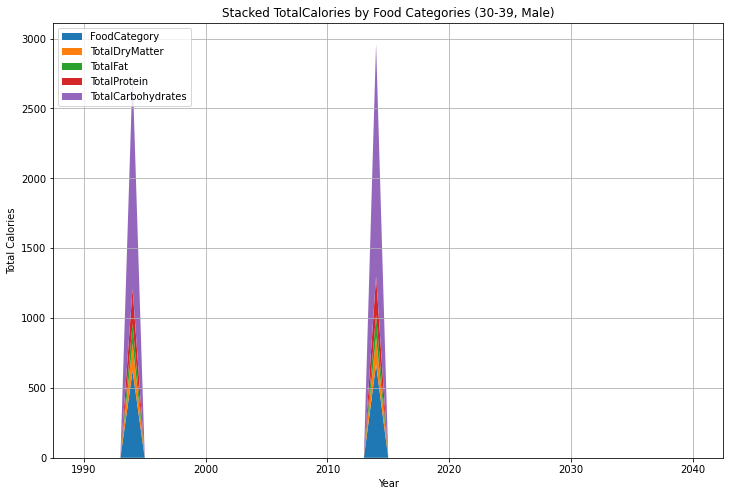

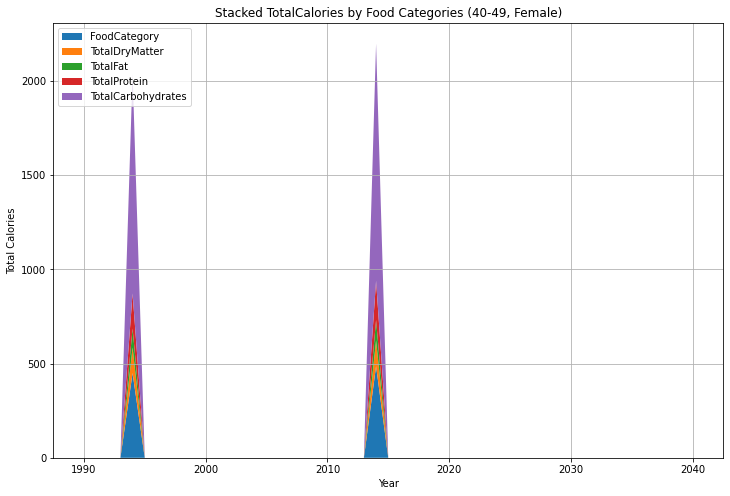

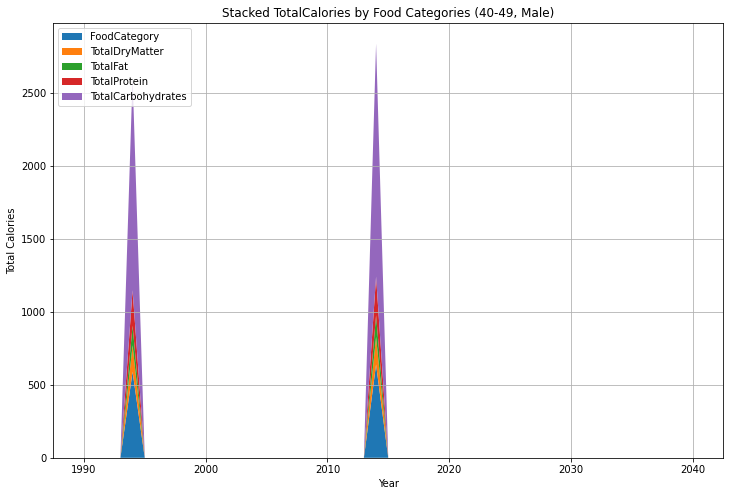

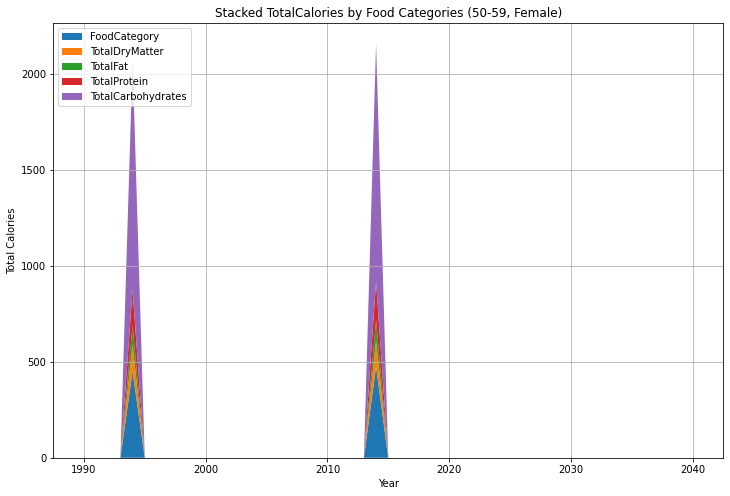

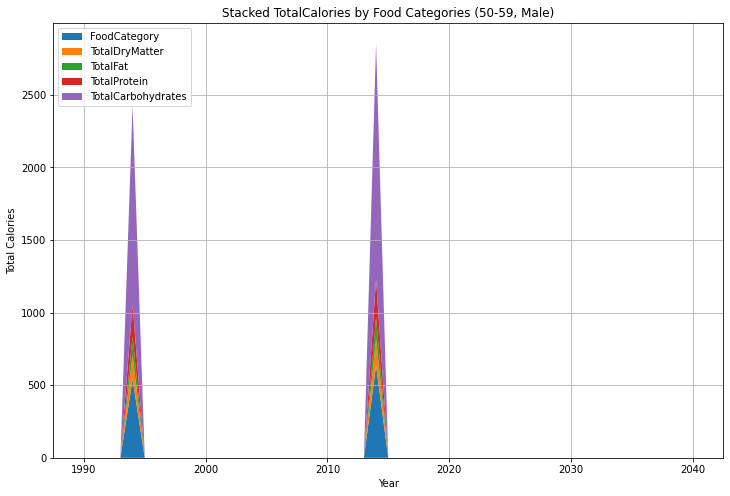

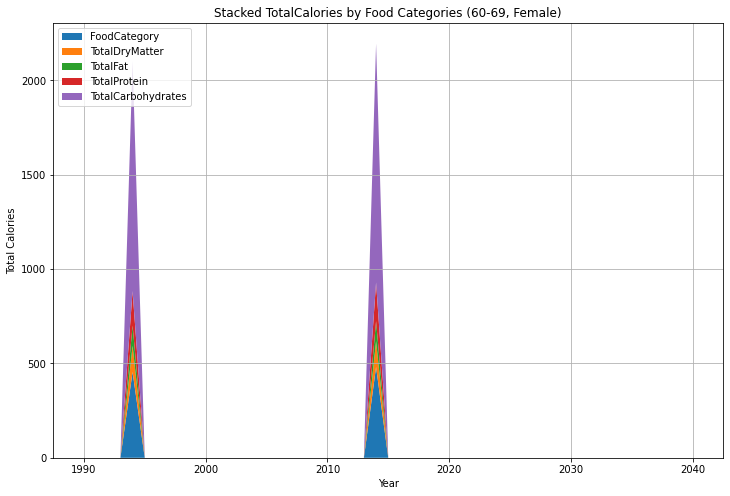

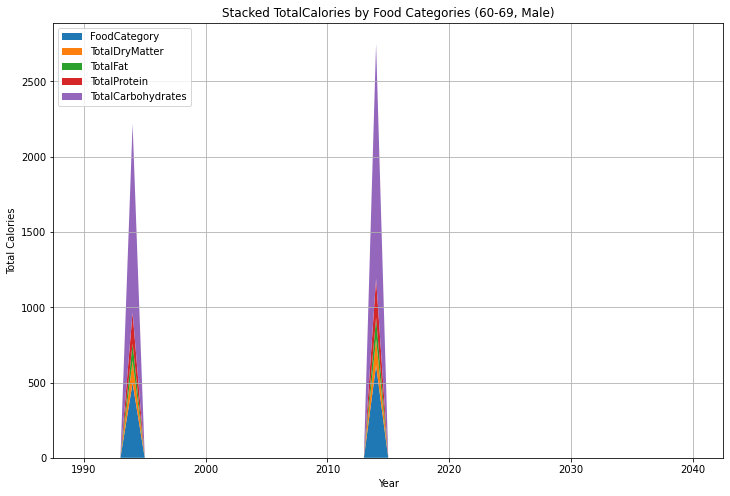

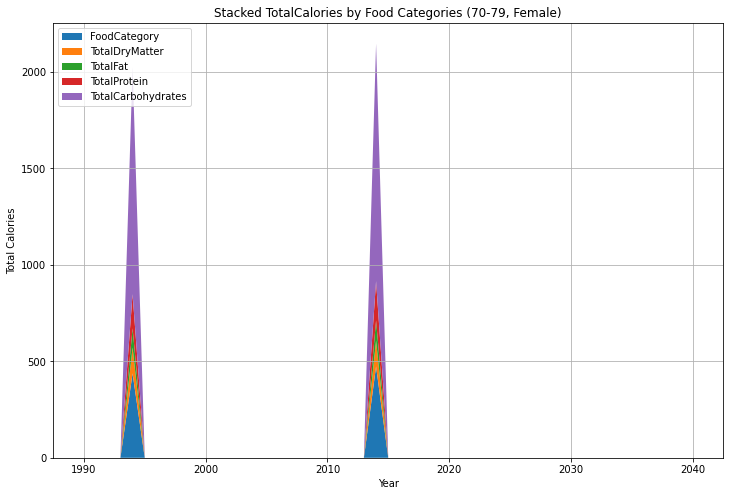

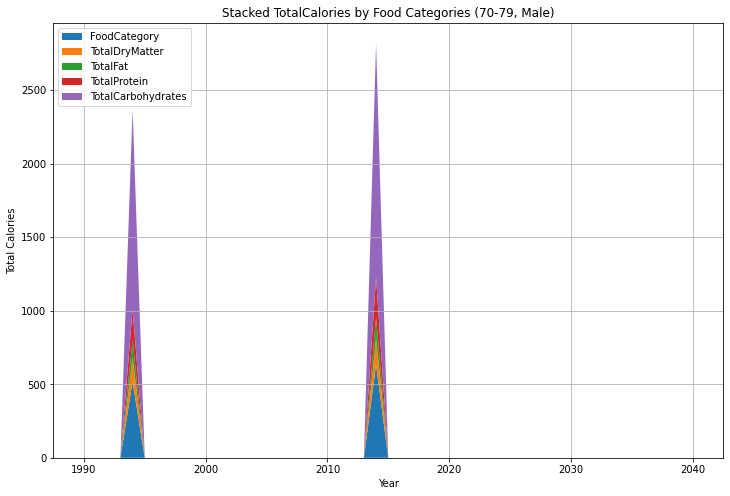

In [65]:
## Data Trend Analysis
# Filter data between 1994 and 2004
filtered_df = nk_df[(nk_df['Year'] >= 1994) & (nk_df['Year'] <= 2004)]

# Fit a polynomial curve for TotalCalories for each AgeGroup and Gender
age_groups = filtered_df['AgeGroup'].unique()
genders = filtered_df['Gender'].unique() if 'Gender' in filtered_df.columns else ['All']

for age_group in age_groups:
    for gender in genders:
        # Filter data for current AgeGroup and Gender
        if gender != 'All':
            age_gender_df = filtered_df[(filtered_df['AgeGroup'] == age_group) & (filtered_df['Gender'] == gender)]
        else:
            age_gender_df = filtered_df[filtered_df['AgeGroup'] == age_group]

        # Extract Year and TotalCalories
        X = age_gender_df['Year'].values.reshape(-1, 1)
        y = age_gender_df['TotalCalories'].values

        # Fit a polynomial curve (degree 2)
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(X)
        model = LinearRegression().fit(X_poly, y)

        # Generate prediction years between 1990 and 2040
        predict_years = np.arange(1990, 2041).reshape(-1, 1)
        predict_years_poly = poly.transform(predict_years)
        predicted_calories = model.predict(predict_years_poly)

        # Plot the fitted curve
        plt.figure(figsize=(10, 6))
        plt.plot(predict_years, predicted_calories, label=f'Fitted Curve ({age_group}, {gender})', linestyle='--')
        plt.scatter(X, y, color='red', label='Original Data Points')
        plt.xlabel('Year')
        plt.ylabel('TotalCalories')
        plt.title(f'TotalCalories Curve Fit for {age_group} ({gender})')
        plt.legend()
        plt.grid(True)
        plt.show()

# Visualization of TotalCalories by food category (stacked area chart) from 1990 to 2040
food_categories = [col for col in nk_df.columns if col not in ['AgeGroup', 'Year', 'Gender', 'TotalCalories', 'AverageEnergyIntake']]
years = np.arange(1990, 2041)

# Prepare data for stacked area plots
for age_group in age_groups:
    for gender in genders:
        if gender != 'All':
            df_group = nk_df[(nk_df['AgeGroup'] == age_group) & (nk_df['Gender'] == gender)]
        else:
            df_group = nk_df[nk_df['AgeGroup'] == age_group]

        grouped_data = df_group.groupby('Year')[food_categories].sum().reindex(years, fill_value=0)

        # Plot stacked area chart for the TotalCalories by food category
        plt.figure(figsize=(12, 8))
        plt.stackplot(years, grouped_data.T, labels=food_categories)
        plt.xlabel('Year')
        plt.ylabel('Total Calories')
        plt.title(f'Stacked TotalCalories by Food Categories ({age_group}, {gender})')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()
